In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.insert(0,'..')
from datahandling import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from configs import TrainConfiguration, ModelConfiguration

nb_classes = 2
data_setting = 'raw'
model_setting = 'conv1d_baseline'#'tsc_fcn_baseline'
splitting='random'

## Data handling

In [6]:
dmel1 = WBDataset(dsname='Melanogaster_RL/Z', clean=True, custom_label=[0])
dmel2 = WBDataset(dsname='Melanogaster_RL/Y', clean=True, custom_label=[0])

dsuz1 = WBDataset(dsname='Suzukii_RL/Y', clean=True, custom_label=[1])
dsuz2 = WBDataset(dsname='Suzukii_RL/X', clean=True, custom_label=[1])

X, y = get_xy_from_datasets(datasets=[dmel1,dsuz1])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

gen_train = WBDataGenerator(X_train, y_train, filtered=True, setting='raw')
gen_val = WBDataGenerator(X_val, y_val, filtered=True, setting='raw')

Found 24763 files.
Found saved cleaned data.
Total number of files after cleaning: 12122.
Label(s) changed to [0]
Found 29002 files.
Found saved cleaned data.
Total number of files after cleaning: 12126.
Label(s) changed to [0]
Found 25732 files.
Found saved cleaned data.
Total number of files after cleaning: 18210.
Label(s) changed to [1]
Found 19657 files.
Found saved cleaned data.
Total number of files after cleaning: 14637.
Label(s) changed to [1]


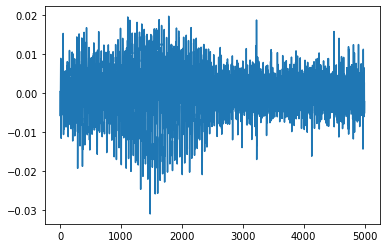

In [13]:
plt.plot(gen_train[0][0][0]);

### Loading free_vs_through data

In [194]:
free_through = np.load(f"{BASE_PROJECTPATH}/temp_data/free_through_mats_stacked.npy")
free_through.shape

(1061, 5000)

In [196]:
df_ft = pd.read_csv(f"{BASE_PROJECTPATH}/temp_data/tsfresh_free_vsthrough.csv")
df_ft.drop('Unnamed: 0', axis=1, inplace=True)
df_ft.sample(5)

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,label
31,0.0,0.0,0.0,0.0,-0.008070,0.071029,0.000839,-4.647065e-07,-4.004476e-08,0.000066,...,0.159721,0.159721,0.290926,0.942132,1.469327,2.310167,3.254791,4.280036,5.347514,fr
413,0.0,0.0,0.0,0.0,0.005768,0.026551,0.000683,-5.905261e-08,3.666441e-08,0.000059,...,0.183378,0.215617,0.352599,1.378714,1.460758,2.309313,3.245025,4.253810,5.291706,fr
535,0.0,0.0,0.0,0.0,-0.055013,0.429919,0.003361,2.146598e-06,1.732997e-06,-0.000114,...,0.217718,0.239211,0.359290,0.904619,1.383072,2.145085,2.982409,3.885789,4.818686,fr
743,0.0,0.0,0.0,1.0,-0.003389,0.071899,0.001700,1.580476e-06,1.362473e-07,-0.000096,...,0.217718,0.262742,0.400065,1.259252,1.437568,2.254379,3.133233,4.079472,5.061734,fr
792,0.0,0.0,0.0,1.0,-0.034785,0.448877,0.003370,-2.941757e-06,-1.839343e-07,-0.000417,...,0.125256,0.245901,0.382629,0.701286,1.372136,2.139508,2.991573,3.880999,4.776566,fr


### calculating extra features

In [141]:
from utils import peak_finder
from scipy.signal import find_peaks

def get_wingbeat_duration(sig):
    sig = pd.Series(sig.squeeze())
    sig = sig.abs().rolling(250).mean()
    points_above_noise = (sig>0.0025).astype(int).sum()
    return  points_above_noise / SR * 1000.

nr_peaks = []
freqs = np.arange(0,4097,1)

amplitudes, frequencies = [],[]
for i in range(len(free_through)):
    data = free_through[i,:]
    _,data = sg.welch(data, fs=8000, scaling='density', window='hanning', nfft=8192, nperseg=256, noverlap=128+64)
    data = preprocessing.normalize(data.reshape(1,-1), norm='l2').T.squeeze()

    peaks, z = find_peaks(data, distance=150, height=0.0005)
    peaks = peaks[peaks>50]
    peaks = peaks[:5]
    
    amplitudes.append(data[peaks])
    frequencies.append(freqs[peaks])

#     plt.plot(data)
#     plt.plot(peaks, data[peaks], "x")
#     plt.show()
    nr_peaks.append(len(peaks))

In [150]:
df_amps = pd.DataFrame(np.stack(amplitudes), columns=[f'amplitude_at_peak{i}' for i in range(5)])
df_freqs = pd.DataFrame(np.stack(frequencies), columns=[f'frequency_at_peak{i}' for i in range(5)])
df_duration = pd.DataFrame([get_wingbeat_duration(free_through[i,:]) for i in range(len(free_through))], columns=['duration_ms'])
df_extra = pd.concat([df_amps,df_freqs, df_duration], axis=1)

In [278]:
df_extra.shape

(1061, 11)

In [303]:
df_free_through = pd.concat([df_extra,df_ft], axis=1, ignore_index=False)

In [304]:
# df_free_through.to_csv(f'{BASE_PROJECTPATH}/temp_data/tsfresh_free_vsthrough_V2.csv')

In [305]:
# df_free_through = df_free_through[df_free_through.label == 'th'].iloc[:,:11]

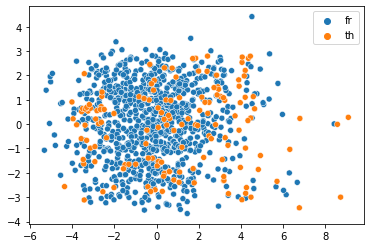

In [306]:
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled = sc.fit_transform(df_free_through.iloc[:,:11].values)

X = scaled
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)
X_pca = np.delete(X_pca, (118,945), axis=0)
labels = np.delete(df_free_through.iloc[:,-1].values, (118,945), axis=0)

sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=labels)

### kmeans

In [307]:
from sklearn.cluster import KMeans

sc = StandardScaler()
scaled = sc.fit_transform(df_free_through.iloc[:,:11].values)

kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit_predict(scaled, y=df_free_through.iloc[:,-1].values)

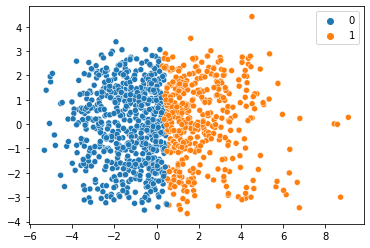

In [308]:
sc = StandardScaler()
scaled = sc.fit_transform(df_free_through.iloc[:,:11].values)

X = scaled
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)
X_pca = np.delete(X_pca, (118,945), axis=0)
labels = np.delete(kmeans, (118,945), axis=0)

sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=labels)

In [318]:
# d = df_free_through[df_free_through.amplitude_at_peak0 < df_free_through.amplitude_at_peak1]

In [319]:
from utils import np_hist

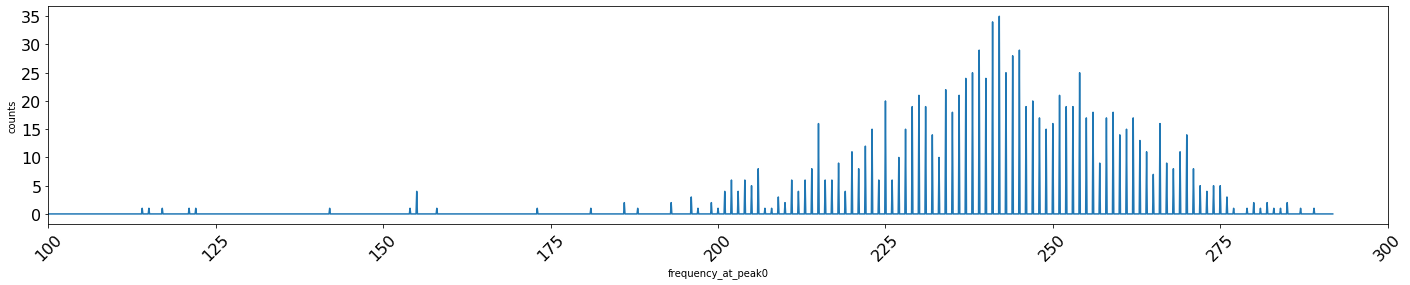

In [330]:
plt.figure(figsize=(24,4));plt.xlim(100,290)
np_hist(df_free_through, 'frequency_at_peak0', fs=16,)

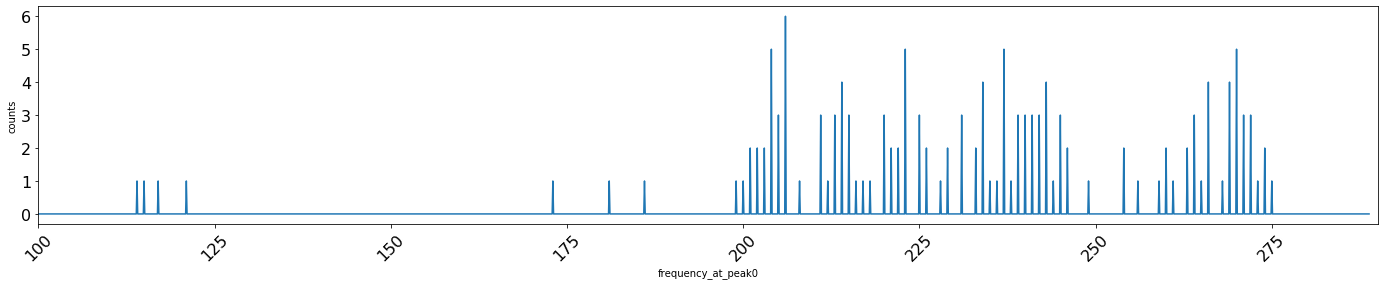

In [331]:
plt.figure(figsize=(24,4));plt.xlim(100,290)
np_hist(df_free_through[df_free_through.label=='th'], 'frequency_at_peak0', fs=16,)

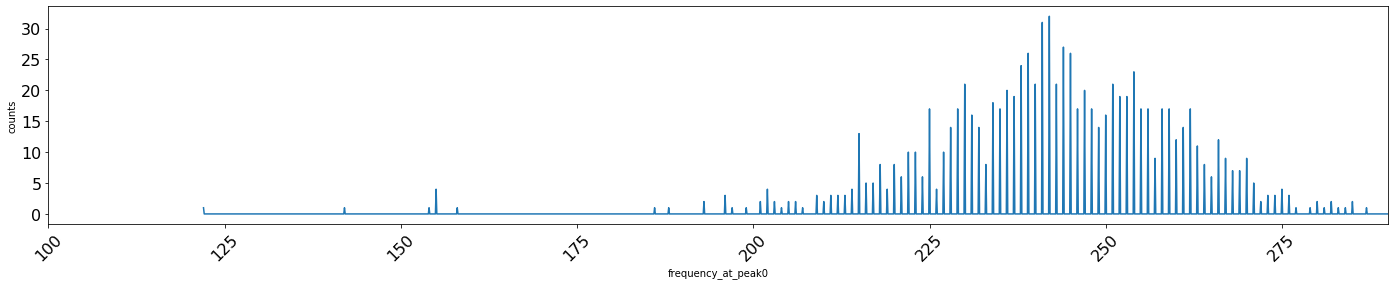

In [332]:
plt.figure(figsize=(24,4));plt.xlim(100,290)
np_hist(df_free_through[df_free_through.label=='fr'], 'frequency_at_peak0', fs=16,)